# [SciPy](https://docs.scipy.org/doc/scipy-1.15.0/index.html#)

<img src="../../Auxiliary_Files/Graphics/Data_Structures/scipy_logo.png" alt="SciPy_Logo" width="600" height="300">

## Table of Contents
- [Introduction](#introduction)
- [Overview](#overview)
- [Arrays](#arrays)
    - [Basic Properties](#basic-properites)
    - [Array Creation Methods]()
    - [Example: Analyzing a 2D Image](#example-analyzing-a-2d-image)
    - [Handling NANS](#handling-nans)
    - [Stacking and Exporting Arrays](#stacking-and-exporting-arrays)
    - [Sorting & Searching](#sorting--searching)
- [Mathematical Routines](#mathematical-routines)
    - [General Functions](#basic-mathematical-functions)
    - [Statistics](#statistics)
    - [Linear Algebra](#linear-algebra)
    - [Simple Polynomial Regression Methods](#simple-polynomial-regression-methods)
- [Exercises](#exercises)
    - [Problem 1: Creating an Array in Four Different Ways](#problem-1-creating-an-array-in-four-different-ways)
    - [Problem 2: Handling NANs](#problem-2-handling-nans)
    - [Problem 3: Modeling Ingress and Egress](#problem-3-modeling-ingress-and-egress)

## Introduction

The [SciPy](https://docs.scipy.org/doc/scipy-1.15.0/index.html#) package contains a slew of different analysis methods and tools that are relevant in exoplanet research. This lesson will focus on these methods, and outline several use cases. 

 <div class="alert alert-block alert-warning">

**NOTE**: SciPy has many high level functions and optimization routines that are largely out of scope of ExoCore. These include routines that may be relevant in other aspects of astrophysics research; if you are interested, check out all SciPy modules [here](https://docs.scipy.org/doc/scipy-1.15.0/reference/index.html).

Before we begin, run the code block below to activate the interactive portions of this lesson:

In [151]:
import scipy
from jupyterquiz import display_quiz
import json
with open("../../Exercise_Solutions/Module_3/SciPy/Checkpoints/questions.json", "r") as file:
    questions=json.load(file)

## `Constants` Module

The first module in SciPy is the Constants module. The utility is in the name; this contains many relevant constants relevant in science and mathematics.

In [152]:
## Evoke pi using scipy.constants.pi

print("The value of pi is: " + str(scipy.constants.pi))

## Speed of light...

c = scipy.constants.c
m_n = scipy.constants.m_n
print("The speed of light is: " + str(c))
print("The mass of the neutron is: " + str(m_n))

The value of pi is: 3.141592653589793
The speed of light is: 299792458.0
The mass of the neutron is: 1.67492749804e-27


You can find a list of available units [here](https://docs.scipy.org/doc/scipy-1.15.0/reference/constants.html). All units are reported in [SI units](https://en.wikipedia.org/wiki/International_System_of_Units#:~:text=The%20SI%20comprises%20a%20coherent,candela%20(cd%2C%20luminous%20intensity)).

### Constants Database
In addition to the built-in constants above, SciPy has integrated an API that allows user to query the [CODATA 2022](https://arxiv.org/abs/2409.03787) constants catalog. This can be navigated using the `value(key)`, `unit(key)`, `precision(key)` and `find([substring, disp])`:

In [153]:
## We want to know the standard acceleration due to gravity
a = scipy.constants.find("gravity", True)

## Value and units

g = scipy.constants.physical_constants['standard acceleration of gravity']

print("The value of g is: " + str(g[0]))
print("The units of g are: " + str(g[1]))
print("The uncertainty of g is: " + str(g[2]))

standard acceleration of gravity
The value of g is: 9.80665
The units of g are: m s^-2
The uncertainty of g is: 0.0


## `Optimize` Module
As with any area of science, we fit models to data. `Scipy` has an `optimize` package which provides a host of fitting routines allow for least-squares regression for non-linear fits. This section goes over the most useful, `curve_fit`, which allows for fitting of nonlienar functions.

Run the cell below to get started:

In [188]:
import scipy.optimize as opt
import numpy as np
from matplotlib import pyplot as plt
## Lists to store data
time = []
flux = []
flux_err = []

## Parameters to base our data on
amp1 = 0.04
amp2 = 0.06
freq = 30
freq2 = 25
for index in range(200):
    index = index/200
    time.append(index)
    flux.append(((amp1)*np.sin(freq*index) +(amp2)*np.sin(freq2*index)) + np.random.normal(1, scale=0.01))
    flux_err.append(0.01)
    


Let's begin by plotting our data above:

Text(0, 0.5, 'Flux')

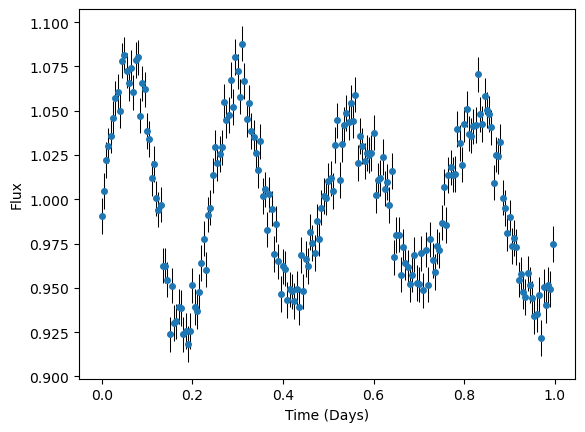

In [179]:
plt.errorbar(time, flux, yerr=flux_err, ecolor='black', elinewidth=0.75, marker='o', linestyle='', markersize=4)
plt.xlabel('Time (Days)')
plt.ylabel('Flux')

Signals similar this can appear in photometric data. They occur due to the rotation of hotspots on the stellar surface. Since the spots are cooler than the rest of the star, the observed flux fluctuates with the period of the star. Multiple hotspots can be present at once, which can give rise to patterns as seen above. Stars also exhibit **differential rotation**, where the star will rotate faster at the equator than at higher or lower latitudes. This can be modeled by a sum of sines:

$$ F(t) = \Sigma^{n}_{i=0} ({A_{i}\sin{\omega_{i}t} + A_{i+1}\sin{\omega_{i+1}t}\cdots})$$
where $A$ is the amplitude in flux change due to the hotspot ($\propto$ spot area relative to the surface) and $\omega$ is the rotation speed of the star at the hot spot's latitutde. Typically, these signals are modeled and subtracted using the Lomb-Scargle Periodogram, which has support using the `astropy` module. For this example, we will model them using `scipy`.

When searching for transit signals, baseline trends (or 'red-noise') caused by stellar activity need to be removed. We will use `curve_fit` for this example to derive values for $A$ and $\omega$.

[ 0.05966186  0.03953501 24.92202065 29.93515046  0.99927256]
A1 is 0.05966186275780372
A2 is 0.03953501313336858
w1 is 24.922020645639734
w2 is 29.935150463646345
b is 0.9992725608479774


Text(0.5, 0, 'Time (days)')

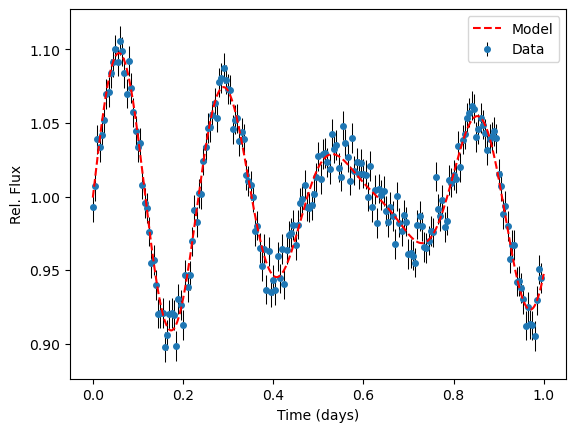

In [191]:
## Create the model to fit
def double_sine(t, a1, a2, w1, w2, b):
    return a1*np.sin(w1*t) + a2*np.sin(w2*t) + b

## To call curve fit, pass the function above along with your data
popt, pcov = opt.curve_fit(double_sine, time, flux, p0=[0.03, 0.02, 30, 30, 1], absolute_sigma=flux_err, maxfev=10000)

print(popt)
## Extract the fitted parameters
print('A1 is ' + str(popt[0]))
print('A2 is ' + str(popt[1]))
print('w1 is ' + str(popt[2]))
print('w2 is ' + str(popt[3]))
print('b is ' + str(popt[4]))
x = np.linspace(0,1, num=1000)
plt.errorbar(time, flux, yerr=flux_err, ecolor='black', elinewidth=0.75, marker='o', linestyle='', markersize=4, zorder=-11, label='Data')
plt.plot(x, double_sine(x, popt[0], popt[1], popt[2], popt[3], popt[4]), linestyle='--', color='red', label='Model')
plt.legend()
plt.ylabel('Rel. Flux')
plt.xlabel('Time (days)')